In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ========================
# Clases auxiliares
# ========================

class Node:
    def __init__(self, id, x, y, dofs):
        self.id = id
        self.x = x
        self.y = y
        self.dofs = np.array(dofs)

class Section:
    def __init__(self, thickness, E, nu, type='planeStress'):
        self.thickness = thickness
        self.E = E
        self.nu = nu
        self.type = type
        self.D = self._compute_D()

    def _compute_D(self):
        if isinstance(self.E, np.ndarray):
            return self.E
        else:
            E, nu = self.E, self.nu
            if self.type == 'planeStress':
                return (E / (1 - nu**2)) * np.array([
                    [1,    nu,       0],
                    [nu,   1,        0],
                    [0,    0, (1 - nu) / 2]
                ])
            elif self.type == 'planeStrain':
                coef = E / ((1 + nu)*(1 - 2*nu))
                return coef * np.array([
                    [1 - nu,     nu,           0],
                    [nu,       1 - nu,         0],
                    [0,         0,   (1 - 2*nu) / 2]
                ])
            else:
                raise ValueError(f"Invalid type: {self.type}. Use 'planeStress' or 'planeStrain'.")

# ========================
# Clase CST
# ========================

class CST:
    def __init__(self, element_tag, node_list, section, load_direction=None, type='planeStress', print_summary=False):
        self.element_tag = element_tag
        self.node_list = node_list
        self.section = section
        self.load_direction = load_direction
        self.type = type
        self.print_summary_flag = print_summary

        self.area = self.compute_area()
        self.B = self.get_B_matrix()
        self.Ke = self.get_stiffness_matrix()

        if print_summary:
            self.printSummary()

    def calculate_indices(self):
        return np.concatenate([node.dofs for node in self.node_list])

    def get_xy_matrix(self):
        return np.array([[node.x, node.y] for node in self.node_list])

    def get_centroid(self):
        xy = self.get_xy_matrix()
        return np.mean(xy, axis=0)

    def compute_area(self):
        x = [node.x for node in self.node_list]
        y = [node.y for node in self.node_list]
        return 0.5 * abs(x[0]*(y[1]-y[2]) + x[1]*(y[2]-y[0]) + x[2]*(y[0]-y[1]))

    def get_interpolation_matrix(self, x, y):
        x1, y1 = self.node_list[0].x, self.node_list[0].y
        x2, y2 = self.node_list[1].x, self.node_list[1].y
        x3, y3 = self.node_list[2].x, self.node_list[2].y
        A = self.area * 2

        N1 = ((x2*y3 - x3*y2) + (y2 - y3)*x + (x3 - x2)*y) / A
        N2 = ((x3*y1 - x1*y3) + (y3 - y1)*x + (x1 - x3)*y) / A
        N3 = ((x1*y2 - x2*y1) + (y1 - y2)*x + (x2 - x1)*y) / A

        return np.array([
            [N1, 0, N2, 0, N3, 0],
            [0, N1, 0, N2, 0, N3],
            [N1, N1, N2, N2, N3, N3]
        ])

    def get_B_matrix(self):
        x = [node.x for node in self.node_list]
        y = [node.y for node in self.node_list]
        A = self.area

        b = [y[1] - y[2], y[2] - y[0], y[0] - y[1]]
        c = [x[2] - x[1], x[0] - x[2], x[1] - x[0]]

        B = np.zeros((3, 6))
        for i in range(3):
            B[0, 2*i]     = b[i]
            B[1, 2*i + 1] = c[i]
            B[2, 2*i]     = c[i]
            B[2, 2*i + 1] = b[i]
        return B / (2 * A)

    def get_stiffness_matrix(self):
        t = self.section.thickness
        D = self.section.D
        A = self.area
        return t * A * self.B.T @ D @ self.B

    def get_body_forces(self, body_force_vector):
        t = self.section.thickness
        A = self.area
        bx, by = body_force_vector
        return (t * A / 3) * np.array([bx, by, bx, by, bx, by])

    def get_point_load_forces(self, x, y, force_vector):
        fx, fy = force_vector
        N = self.get_interpolation_matrix(x, y)
        return N.T @ np.array([fx, fy, 0])

    def plotGeometry(self):
        coords = self.get_xy_matrix()
        coords = np.vstack([coords, coords[0]])
        plt.plot(coords[:, 0], coords[:, 1], 'k-o')
        for node in self.node_list:
            plt.text(node.x, node.y, f'N{node.id}', color='blue')
        centroid = self.get_centroid()
        plt.text(centroid[0], centroid[1], f'E{self.element_tag}', color='red')
        plt.axis('equal')
        plt.title(f'CST Element {self.element_tag}')
        plt.grid(True)
        plt.show()

    def printSummary(self):
        print(f"\nCST Element {self.element_tag}")
        print(f"Type: {self.type}")
        print("\nNodes:")
        for node in self.node_list:
            print(f"\tNode {node.id}: ({node.x}, {node.y}) DOFs: {node.dofs}")
        print(f"\nArea: {self.area}")
        print("\nStiffness matrix Ke:")
        print(self.Ke)
        centroid = self.get_centroid()
        print(f"\nCentroid: ({centroid[0]}, {centroid[1]})")
        print('\nBody forces:')
        if self.load_direction is not None:
            print(f"Direction: {self.load_direction}")
        else:
            print("No body forces applied.")


In [2]:
# ========================
# Definición del caso de estudio
# ========================

# Nodos
node1 = Node(1, 0.0, 0.0, [0, 1])
node2 = Node(2, 3.0, 1.0, [2, 3])
node3 = Node(3, 2.0, 2.0, [4, 5])
nodes = [node1, node2, node3]

# Propiedades del material
E = 8 * np.array([[4,1,0],
                  [1,4,0],
                  [0,0,2]])
nu = 0.3
t = 1

# Sección
section = Section(thickness=t, E=E, nu=nu, type='planeStress')

# Elemento CST
element = CST(element_tag=1, node_list=nodes, section=section, type='planeStress', print_summary=True)

# ========================
# Resultados y validaciones
# ========================

# Eigenvalores
np.set_printoptions(precision=2, suppress=True)
eigvals = np.linalg.eigvals(element.Ke)
eigvals_real = np.real_if_close(eigvals, tol=1e-5)
eigvals_rounded = np.round(eigvals_real, 4)
print("\nValores propios de Ke (solo parte real):")
print(eigvals_rounded)

# Verificación de simetría
print("\n¿Ke es simétrica?:", np.allclose(element.Ke, element.Ke.T, atol=1e-8))

# Carga de cuerpo constante
bf = element.get_body_forces([1000, 0])
print("\nFuerzas nodales equivalentes por carga de cuerpo:")
print(bf)

# Carga puntual en centroide, transformada a carga distribuida
F = np.array([100, -200])
A = element.area
b_equiv = F / (A * t)
f_body_equiv = element.get_body_forces(b_equiv)

print("\nFuerza puntual convertida a carga distribuida equivalente:")
print("Carga distribuida (b):", np.round(b_equiv, 2))
print("Fuerzas nodales equivalentes usando get_body_forces():")
print(np.round(f_body_equiv, 2))

# --- Plot opcional ---
# element.plotGeometry()



CST Element 1
Type: planeStress

Nodes:
	Node 1: (0.0, 0.0) DOFs: [0 1]
	Node 2: (3.0, 1.0) DOFs: [2 3]
	Node 3: (2.0, 2.0) DOFs: [4 5]

Area: 2.0

Stiffness matrix Ke:
[[  6.   3.  -4.  -2.  -2.  -1.]
 [  3.   6.   2.   4.  -5. -10.]
 [ -4.   2.  24. -12. -20.  10.]
 [ -2.   4. -12.  24.  14. -28.]
 [ -2.  -5. -20.  14.  22.  -9.]
 [ -1. -10.  10. -28.  -9.  38.]]

Centroid: (1.6666666666666667, 1.0)

Body forces:
No body forces applied.

Valores propios de Ke (solo parte real):
[75.53 -0.   11.6  32.86 -0.   -0.  ]

¿Ke es simétrica?: True

Fuerzas nodales equivalentes por carga de cuerpo:
[666.67   0.   666.67   0.   666.67   0.  ]

Fuerza puntual convertida a carga distribuida equivalente:
Carga distribuida (b): [  50. -100.]
Fuerzas nodales equivalentes usando get_body_forces():
[ 33.33 -66.67  33.33 -66.67  33.33 -66.67]



CST Element 1
Type: planeStress

Nodes:
	Node 1: (0.0, 0.0) DOFs: [0 1]
	Node 2: (3.0, 1.0) DOFs: [2 3]
	Node 3: (2.0, 2.0) DOFs: [4 5]

Area: 2.0

Stiffness matrix Ke:
[[  6.   3.  -4.  -2.  -2.  -1.]
 [  3.   6.   2.   4.  -5. -10.]
 [ -4.   2.  24. -12. -20.  10.]
 [ -2.   4. -12.  24.  14. -28.]
 [ -2.  -5. -20.  14.  22.  -9.]
 [ -1. -10.  10. -28.  -9.  38.]]

Centroid: (1.6666666666666667, 1.0)

Body forces:
No body forces applied.

Valores propios de Ke (solo parte real):
[75.53 -0.   11.6  32.86 -0.   -0.  ]

¿Ke es simétrica?: True

Fuerzas nodales equivalentes por carga de cuerpo:
[666.67   0.   666.67   0.   666.67   0.  ]

Fuerza puntual convertida a carga distribuida equivalente:
Carga distribuida (b): [  50. -100.]
Fuerzas nodales equivalentes usando get_body_forces():
[ 33.33 -66.67  33.33 -66.67  33.33 -66.67]


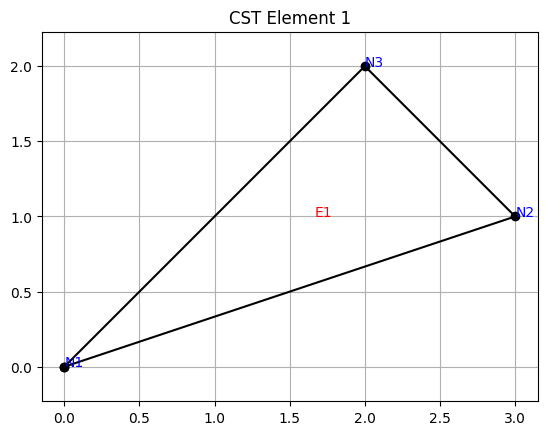

In [3]:
# ========================
# Definición del caso de estudio
# ========================

# Nodos
node1 = Node(1, 0.0, 0.0, [0, 1])
node2 = Node(2, 3.0, 1.0, [2, 3])
node3 = Node(3, 2.0, 2.0, [4, 5])
nodes = [node1, node2, node3]

# Propiedades del material
E = 8 * np.array([[4,1,0],
                  [1,4,0],
                  [0,0,2]])
nu = 0.3
t = 1

# Sección
section = Section(thickness=t, E=E, nu=nu, type='planeStress')

# Elemento CST
element = CST(element_tag=1, node_list=nodes, section=section, type='planeStress', print_summary=True)

# ========================
# Resultados y validaciones
# ========================

# Eigenvalores
np.set_printoptions(precision=2, suppress=True)
eigvals = np.linalg.eigvals(element.Ke)
eigvals_real = np.real_if_close(eigvals, tol=1e-5)
eigvals_rounded = np.round(eigvals_real, 4)
print("\nValores propios de Ke (solo parte real):")
print(eigvals_rounded)

# Verificación de simetría
print("\n¿Ke es simétrica?:", np.allclose(element.Ke, element.Ke.T, atol=1e-8))

# Carga de cuerpo constante
bf = element.get_body_forces([1000, 0])
print("\nFuerzas nodales equivalentes por carga de cuerpo:")
print(bf)

# Carga puntual en centroide, transformada a carga distribuida
F = np.array([100, -200])
A = element.area
b_equiv = F / (A * t)
f_body_equiv = element.get_body_forces(b_equiv)

print("\nFuerza puntual convertida a carga distribuida equivalente:")
print("Carga distribuida (b):", np.round(b_equiv, 2))
print("Fuerzas nodales equivalentes usando get_body_forces():")
print(np.round(f_body_equiv, 2))

# --- Plot opcional ---
element.plotGeometry()
